In [1]:
from sqlalchemy import create_engine

# HOST = "gateway01.us-west-2.prod.aws.tidbcloud.com"
# PORT = 4000
# USR = "4JHciBfpftZR67E.root"
# PWD = "aidBsAjcm2YUaFac"
# DB = "data"
# database_url = f"mysql+mysqldb://{USR}:{PWD}@{HOST}:{PORT}/{DB}"

database_url = 'sqlite:///../data/data.sqlite'

# 创建数据库引擎
engine = create_engine(database_url)

In [2]:
import pandas as pd

# query = "select trend from hk_pred_trend"
query = "select gl机场入境 as trend from hk_immigration_selected"
df = pd.read_sql_query(query, engine).astype('float64')

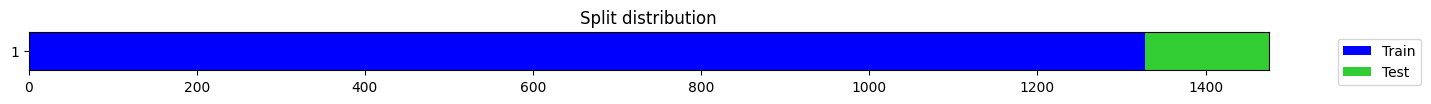

In [3]:
from tsai.data.validation import get_splits
from tsai.data.core import get_ts_dls
from tsai.data.preparation import df2xy, apply_sliding_window, SlidingWindow

window_length = 5
stride = None
horizon = 1

X, y = apply_sliding_window(df, window_len=window_length, horizon=horizon)
dls = get_ts_dls(X, y, bs=64, splits=get_splits(y, valid_size=.1, stratify=True, random_state=23, shuffle=False))

In [4]:
from tsai.models.utils import count_parameters
from tsai.models.TST import TST

bs = 64
c_in = 1  # aka channels, features, variables, dimensions
c_out = 1
seq_len = 50

# Settings
max_seq_len = 8
d_model = 128
n_heads = 16
d_k = d_v = None  # if None --> d_model // n_heads
d_ff = 256
dropout = 0.1
activation = "gelu"
n_layers = 3
fc_dropout = 0.1
kwargs = {}

model = TST(c_in, c_out, seq_len, max_seq_len=max_seq_len, d_model=d_model, n_heads=n_heads,
            d_k=d_k, d_v=d_v, d_ff=d_ff, dropout=dropout, activation=activation, n_layers=n_layers,
            fc_dropout=fc_dropout, kernel_size=64, stride=2, padding=60)
print(f'model parameters: {count_parameters(model)}')

model parameters: 398977


epoch,train_loss,valid_loss,_rmse,accuracy,time
0,21108536.000000,267488576.000000,16355.077148,0.000000,00:00
1,20777824.000000,267370000.000000,16351.452148,0.000000,00:00
2,20999352.000000,266903888.000000,16337.193359,0.000000,00:00
3,20918164.000000,265826144.000000,16304.174805,0.000000,00:00
4,20812092.000000,265902592.000000,16306.519531,0.000000,00:00
5,20875972.000000,262707184.000000,16208.244141,0.000000,00:00
6,20750784.000000,262110640.000000,16189.831055,0.000000,00:00
7,20595778.000000,258332608.000000,16072.728516,0.000000,00:00
8,20547826.000000,254531488.000000,15954.041992,0.000000,00:00
9,20238232.000000,256536016.000000,16016.743164,0.000000,00:00


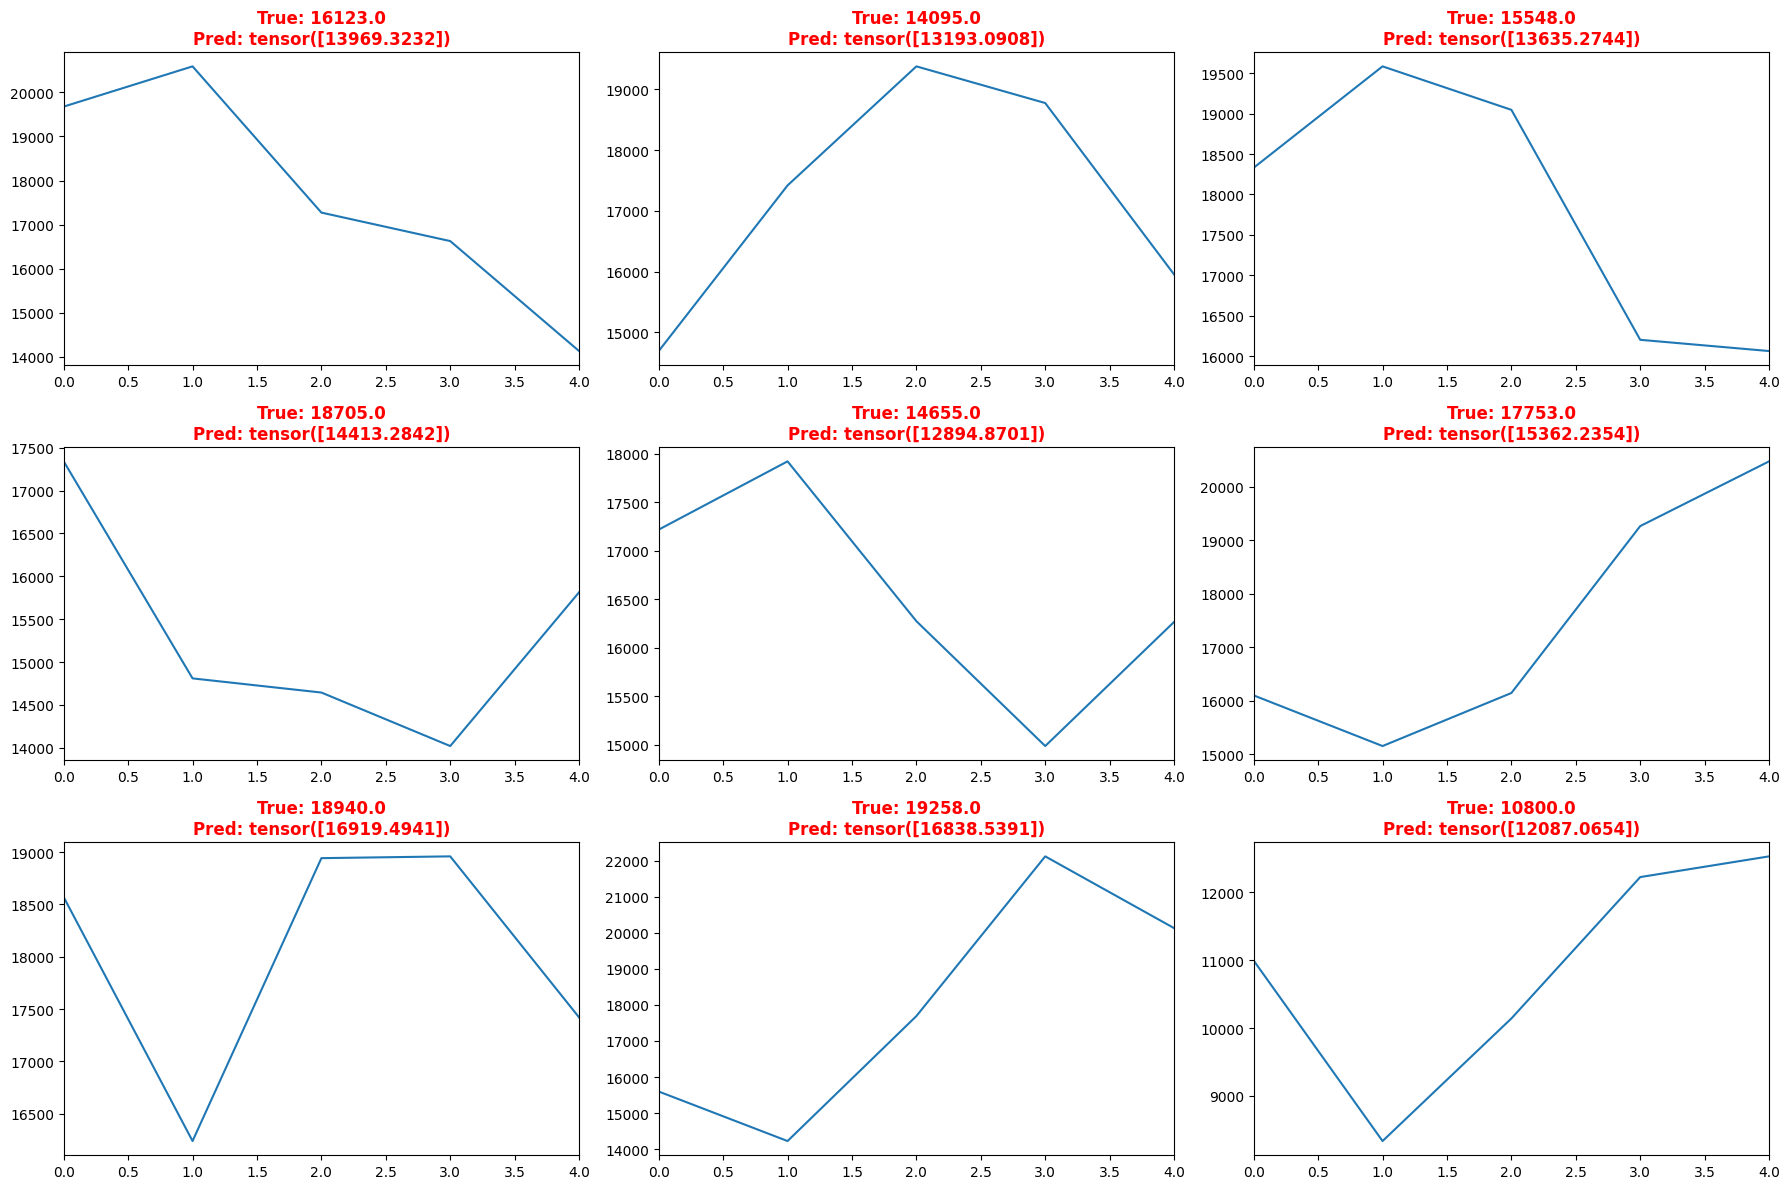

In [5]:
from fastai.metrics import mae, rmse, accuracy
from fastai.learner import Learner
from fastai.losses import MSELossFlat
from fastai.callback.progress import ShowGraphCallback

learn = Learner(dls, model, metrics=[rmse, accuracy], loss_func=MSELossFlat())
learn.fit(100)# 训练10个epochs

# 步骤7: 评估模型
learn.show_results()

In [6]:
# 假设X是你想预测的数据集
dl = learn.dls.valid
preds = learn.get_preds(dl=dl)


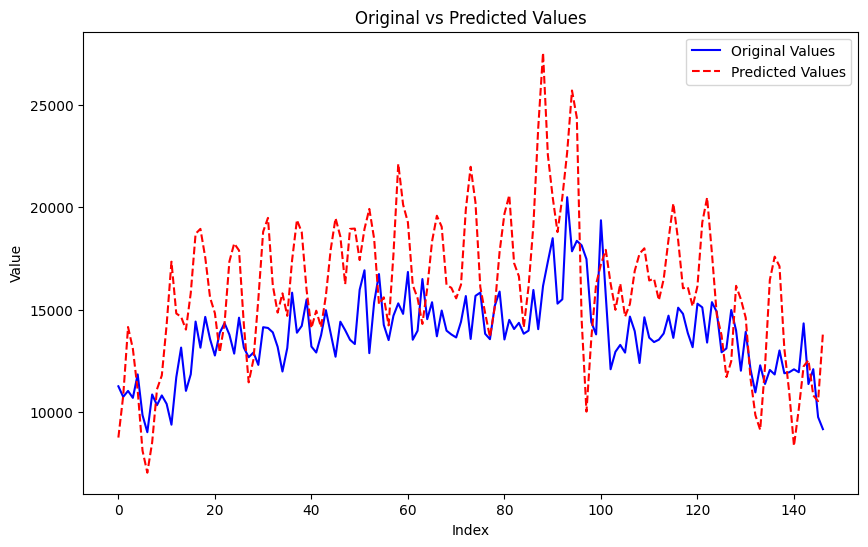

In [7]:
import matplotlib.pyplot as plt

# 假设pred是你的预测结果，其中pred[0]是原始值，pred[1]是预测值
# 例如: pred = (y_true, y_pred)

# 解包pred元组以获取原始值和预测值
y_true, y_pred = preds

# 使用matplotlib绘制原始值和预测值
plt.figure(figsize=(10, 6))  # 设置图形的大小
plt.plot(y_true, label='Original Values', color='blue')  # 绘制原始值
plt.plot(y_pred, label='Predicted Values', color='red', linestyle='--')  # 绘制预测值，使用虚线
plt.title('Original vs Predicted Values')  # 设置图形标题
plt.xlabel('Index')  # 设置x轴标签
plt.ylabel('Value')  # 设置y轴标签
plt.legend()  # 显示图例
plt.show()  # 显示图形
